Let's focus on the clusters which have only one transport domain. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [152]:
LEFTOUT_BGC = 'BGC0001482' # This BGC doesn't have metadata, for some reason.

In [235]:
mibig_counts_df = pd.read_csv('mibig_table.tsv', sep='\t')
mibig_counts_df = mibig_counts_df[mibig_counts_df['BGC'] != LEFTOUT_BGC]
mibig_counts = mibig_counts_df.to_numpy()[:, 1:17]
pfam_colnames = mibig_counts_df.columns[1:17]

mibig_uniques = mibig_counts.astype(bool).astype(int) 

bgc_counts = np.sum(mibig_counts, axis=1)
bgc_unique_counts = np.sum(mibig_uniques, axis=1)

In [217]:
# Load the metadata and filter to ones with transporters

_mibig_meta = pd.read_csv('data_mibig_fixed.tsv', sep='\t') # Lots of stuff with no transporters present
mibig_meta = _mibig_meta[_mibig_meta['BGC'].isin(mibig_counts_df['BGC'])].reset_index(drop=True)

# Make sure mibig_meta and mibig_counts_df agree have same index
# There should be a clean pandas way to do this, but shrug

# Create dict with mibig_counts_df order
int_to_bgc = dict(enumerate(mibig_df['BGC']))
bgc_to_int = {v: k for k,v in int_to_bgc.items()}

# Now add this column unordered to mibig_meta and sort it
mibig_meta['idx'] = [bgc_to_int[name] for name in mibig_meta['BGC']]
mibig_meta = mibig_meta.sort_values(by='idx', ascending=True)

# Now drop the idx column and reset index
mibig_meta = mibig_meta.drop(columns='idx')
mibig_meta = mibig_meta.reset_index(drop=True)

assert list(mibig_meta['BGC']) == list(mibig_counts_df['BGC']), 'BGC of metadata and counts do not agree. Check ordering.'

Let's take a look at the distribution of counts first. 

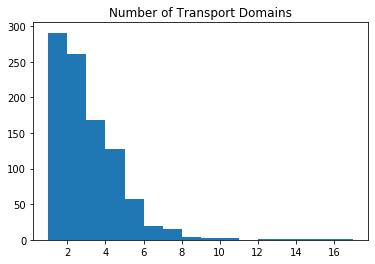

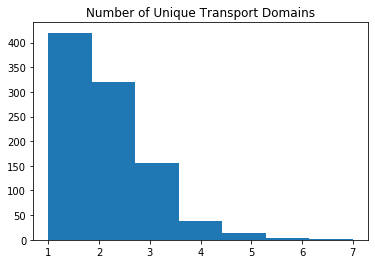

In [61]:
plt.hist(bgc_counts, bins=16)
plt.title('Number of Transport Domains')
plt.show()

plt.hist(bgc_unique_counts, bins=7)
plt.title('Number of Unique Transport Domains')
plt.show()

These plots show us a few things. First, most of our BGCs have very few called transport domains. Second, they tend to have only a couple present. Let's dig deeper into the simplest case - only one domain present.

In [223]:
single_domain_mibig_idx = np.where(bgc_unique_counts == 1)

mibig_counts_single_domain = mibig_counts[single_domain_mibig_idx]
mibig_uniques_single_domain = mibig_uniques[single_domain_mibig_idx]
meta_single_domain = mibig_meta.loc[single_domain_mibig_idx].reset_index(drop=True)

First question, which PFAM families tend to show up on their own?

In [79]:
pfam_frequencies = np.argmax(mibig_uniques_single_domain, axis=1)
pfam_frequencies = np.bincount(pfam_frequencies)
pfam_frequencies = pfam_frequencies/(np.sum(pfam_frequencies))

420


In [106]:
#legend_labels = [name + ' ' + str(round(100*percent, 2)) + '%' for name, percent in zip(mibig_df.columns[1:17], pfam_frequencies)]

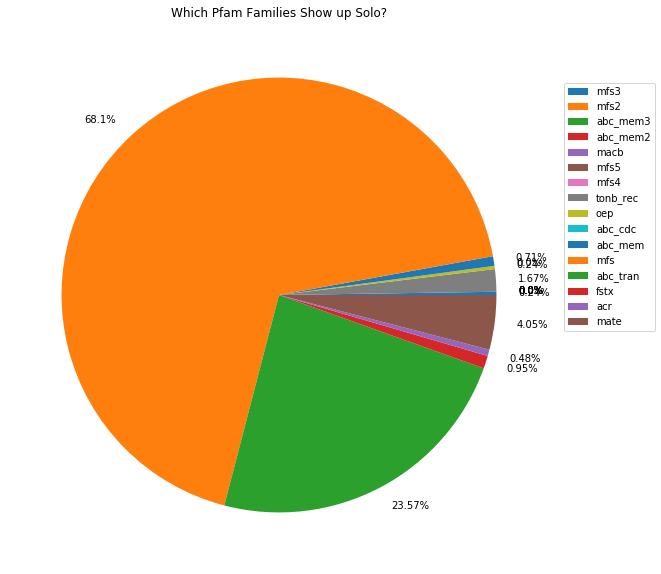

In [126]:
frequency_labels = [str(round(100*percent, 2)) + '%' for percent in pfam_frequencies]
plt.figure(figsize=(10,10))
plt.pie(pfam_frequencies, labels=frequency_labels)
plt.legend(mibig_df.columns[1:17], loc=1,  bbox_to_anchor=(1.2, 0.9))
plt.title('Which Pfam Families Show up Solo?')
plt.show()

Are there any trends in which singleton families are tagged in which kinds of clusters? 

In [281]:
def plot_domain_counts_by_trait(counts: np.ndarray,
                                traits: pd.Series,
                                title: str) -> None:
    """ Plots counts for a domain for each value of a discrete trait.
    
    Inputs:
        counts - Array of shape [N, 1]
        traits - Pandas Series / Array of shape [N] with K distinct values.
    Outputs:
        K histogram plots (currently just printed)
    """
    unique_values = np.unique(traits)
    cmap = plt.get_cmap('Accent')
    for i, value in enumerate(unique_values):
        current_idx = traits == value
        current_counts = counts[current_idx]
        maximum = np.max(current_counts)
        plt.hist(current_counts, bins=np.arange(1, maximum + 2), color=cmap(i/len(unique_values)), label=value)

    plt.title(title)
    plt.legend()
    plt.show()

In [240]:
list(enumerate(pfam_colnames))

[(0, 'mfs3'),
 (1, 'mfs2'),
 (2, 'abc_mem3'),
 (3, 'abc_mem2'),
 (4, 'macb'),
 (5, 'mfs5'),
 (6, 'mfs4'),
 (7, 'tonb_rec'),
 (8, 'oep'),
 (9, 'abc_cdc'),
 (10, 'abc_mem'),
 (11, 'mfs'),
 (12, 'abc_tran'),
 (13, 'fstx'),
 (14, 'acr'),
 (15, 'mate')]

In [274]:
traits_of_interest = ['Antibacterial', 'Antifungal', 'Siderophore', 'Gram', 'Type']

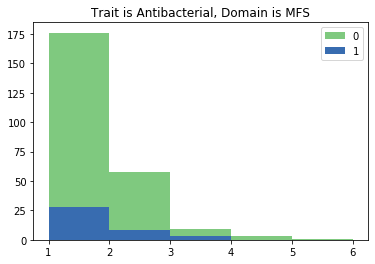

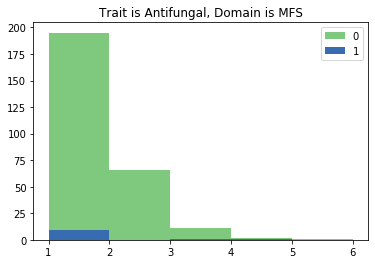

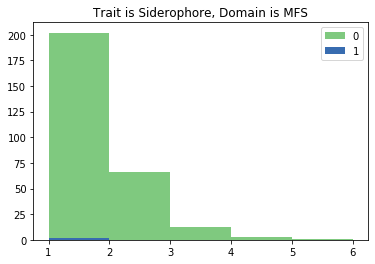

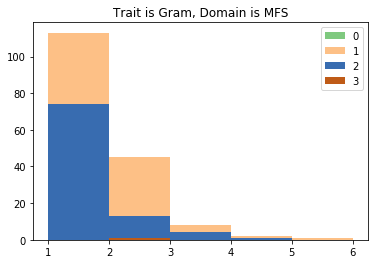

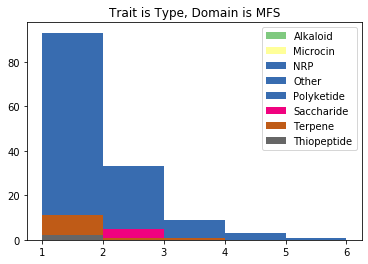

In [283]:
mfs_counts = mibig_counts_single_domain[:, 11]

for trait in traits_of_interest:
    title = f'Trait is {trait}, Domain is MFS'
    plot_domain_counts_by_trait(mfs_counts, meta_single_domain[trait], title = title)

In [285]:
list(enumerate(pfam_colnames))

[(0, 'mfs3'),
 (1, 'mfs2'),
 (2, 'abc_mem3'),
 (3, 'abc_mem2'),
 (4, 'macb'),
 (5, 'mfs5'),
 (6, 'mfs4'),
 (7, 'tonb_rec'),
 (8, 'oep'),
 (9, 'abc_cdc'),
 (10, 'abc_mem'),
 (11, 'mfs'),
 (12, 'abc_tran'),
 (13, 'fstx'),
 (14, 'acr'),
 (15, 'mate')]

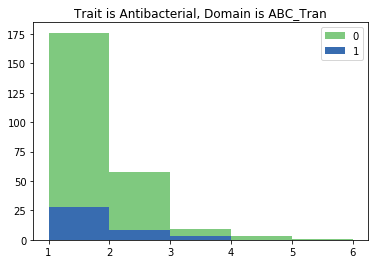

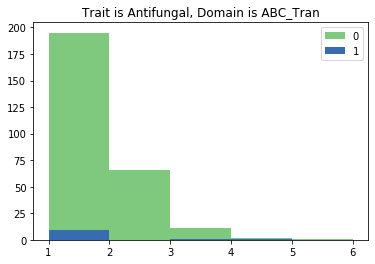

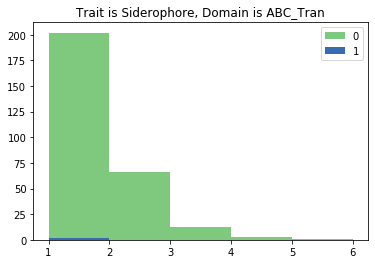

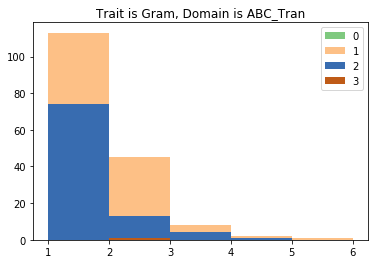

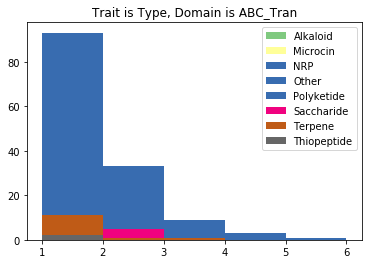

In [287]:
abc_counts = mibig_counts_single_domain[:, 12]

for trait in traits_of_interest:
    title = f'Trait is {trait}, Domain is ABC_Tran'
    plot_domain_counts_by_trait(mfs_counts, meta_single_domain[trait], title = title)

Do decision trees find anything more interesting?

Only using mfs counts

In [329]:
from typing import List

from sklearn import tree

In [367]:
def fit_and_plot_tree(counts: np.ndarray,
                      trait: np.ndarray,
                      feature_names: List[str]=None,
                      trait_name: str=None) -> tree.DecisionTreeClassifier:
    """ Fit a decision tree and plot the result.
    
    Input:
        counts: Matrix of size [N, num_domains]
        trait: Array of shape [N] with K unique values
    Returns:
        tree: tree.DecisionTreeClassifier
    
    Also plots the tree as a side effect.
    """
    clf = tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced')
    clf = clf.fit(counts, trait)
    
    names = [str(i) for i in np.unique(trait)]
    plt.figure(figsize=(35,35))
    tree.plot_tree(clf, 
                   class_names=names, 
                   filled=True, 
                   proportion=True, 
                   feature_names=feature_names, 
                   impurity=False,
                   fontsize=15,
                   rotate=True)
    plt.savefig(f'tree_plot_{trait_name}.png')
    
    return clf

A tree using only MFS counts

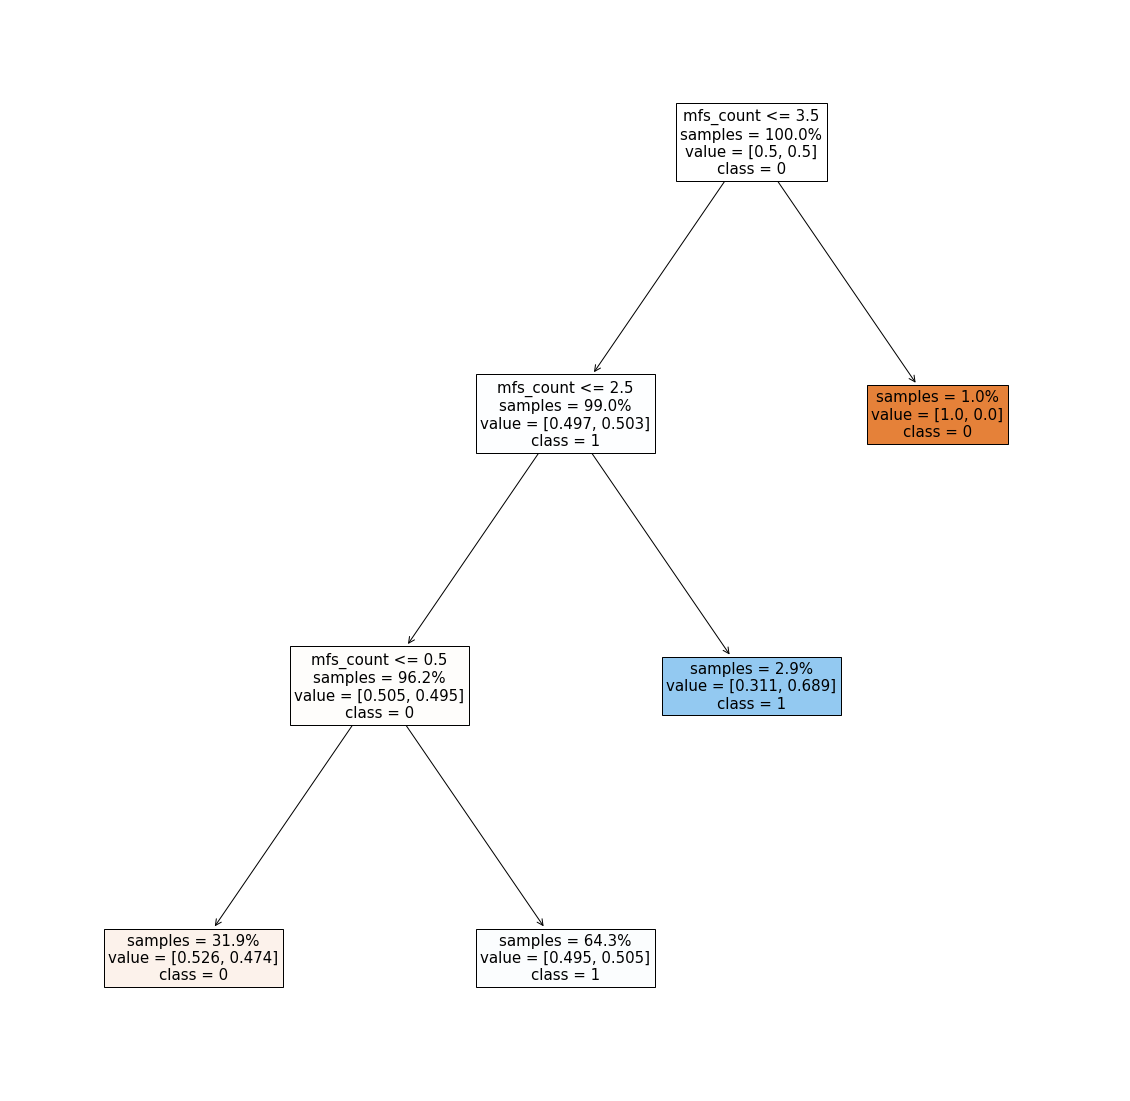

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [354]:
trait = np.array(meta_single_domain['Antibacterial'])
fit_and_plot_tree(mfs_counts.reshape(-1,1), trait, ['mfs_count'])

A tree using only abc_tran

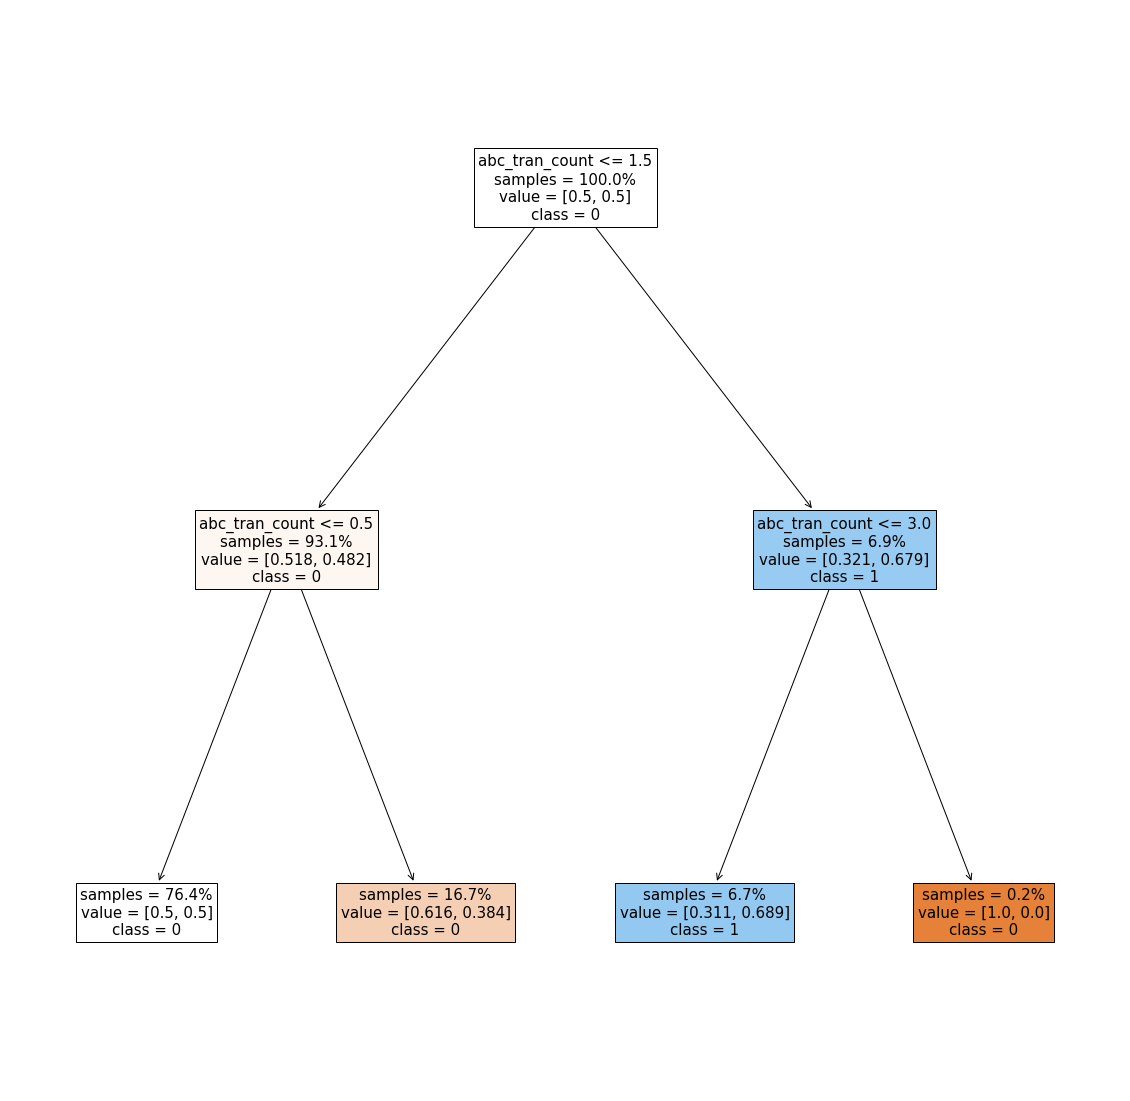

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [355]:
trait = np.array(meta_single_domain['Antibacterial'])
fit_and_plot_tree(abc_counts.reshape(-1,1), trait, ['abc_tran_count'])

A tree using both.

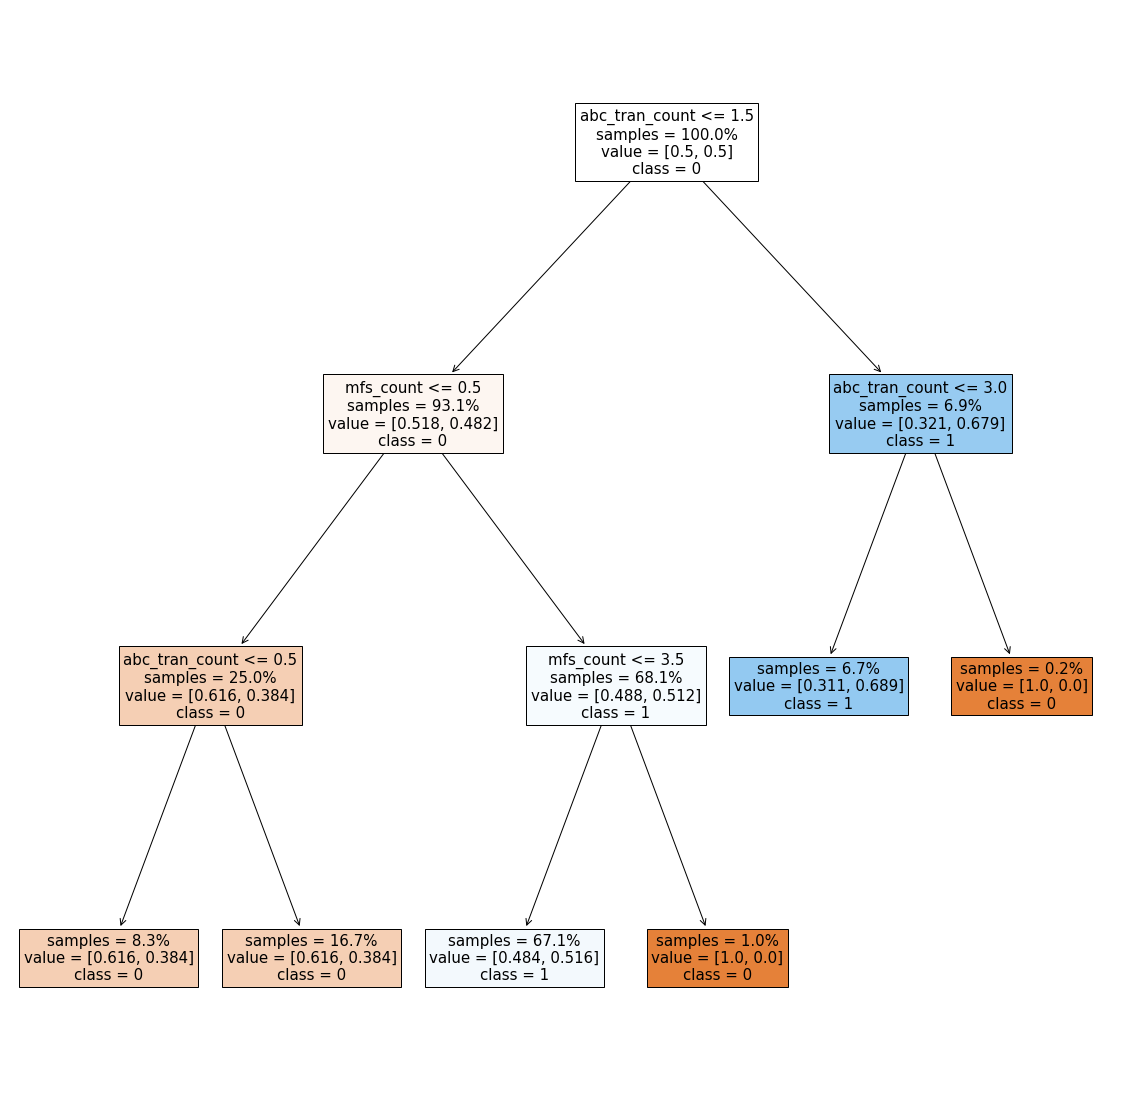

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [356]:
trait = np.array(meta_single_domain['Antibacterial'])
fit_and_plot_tree(np.stack((abc_counts, mfs_counts), axis=1), trait, ['abc_tran_count', 'mfs_count'])

A tree using all of them

In [342]:
pfam_colnames

Index(['mfs3', 'mfs2', 'abc_mem3', 'abc_mem2', 'macb', 'mfs5', 'mfs4',
       'tonb_rec', 'oep', 'abc_cdc', 'abc_mem', 'mfs', 'abc_tran', 'fstx',
       'acr', 'mate'],
      dtype='object')

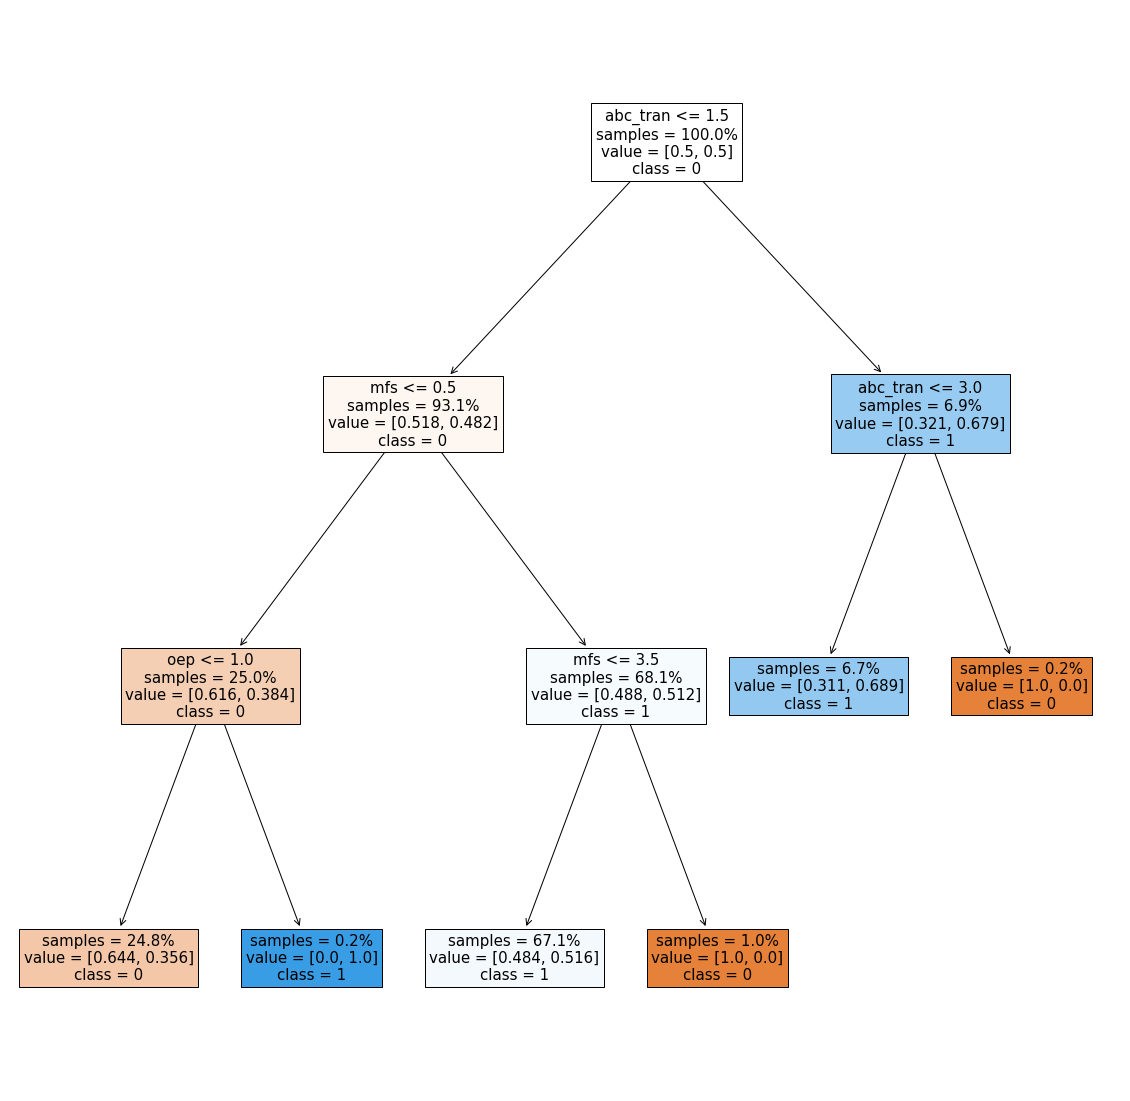

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [357]:
trait = np.array(meta_single_domain['Antibacterial'])
fit_and_plot_tree(mibig_counts_single_domain, trait, pfam_colnames)

Trying it for the entire dataset now.

----------------------------------------------------------------------
Trait is Antibacterial
----------------------------------------------------------------------
----------------------------------------------------------------------
Trait is Antifungal
----------------------------------------------------------------------
----------------------------------------------------------------------
Trait is Siderophore
----------------------------------------------------------------------
----------------------------------------------------------------------
Trait is Gram
----------------------------------------------------------------------
----------------------------------------------------------------------
Trait is Type
----------------------------------------------------------------------


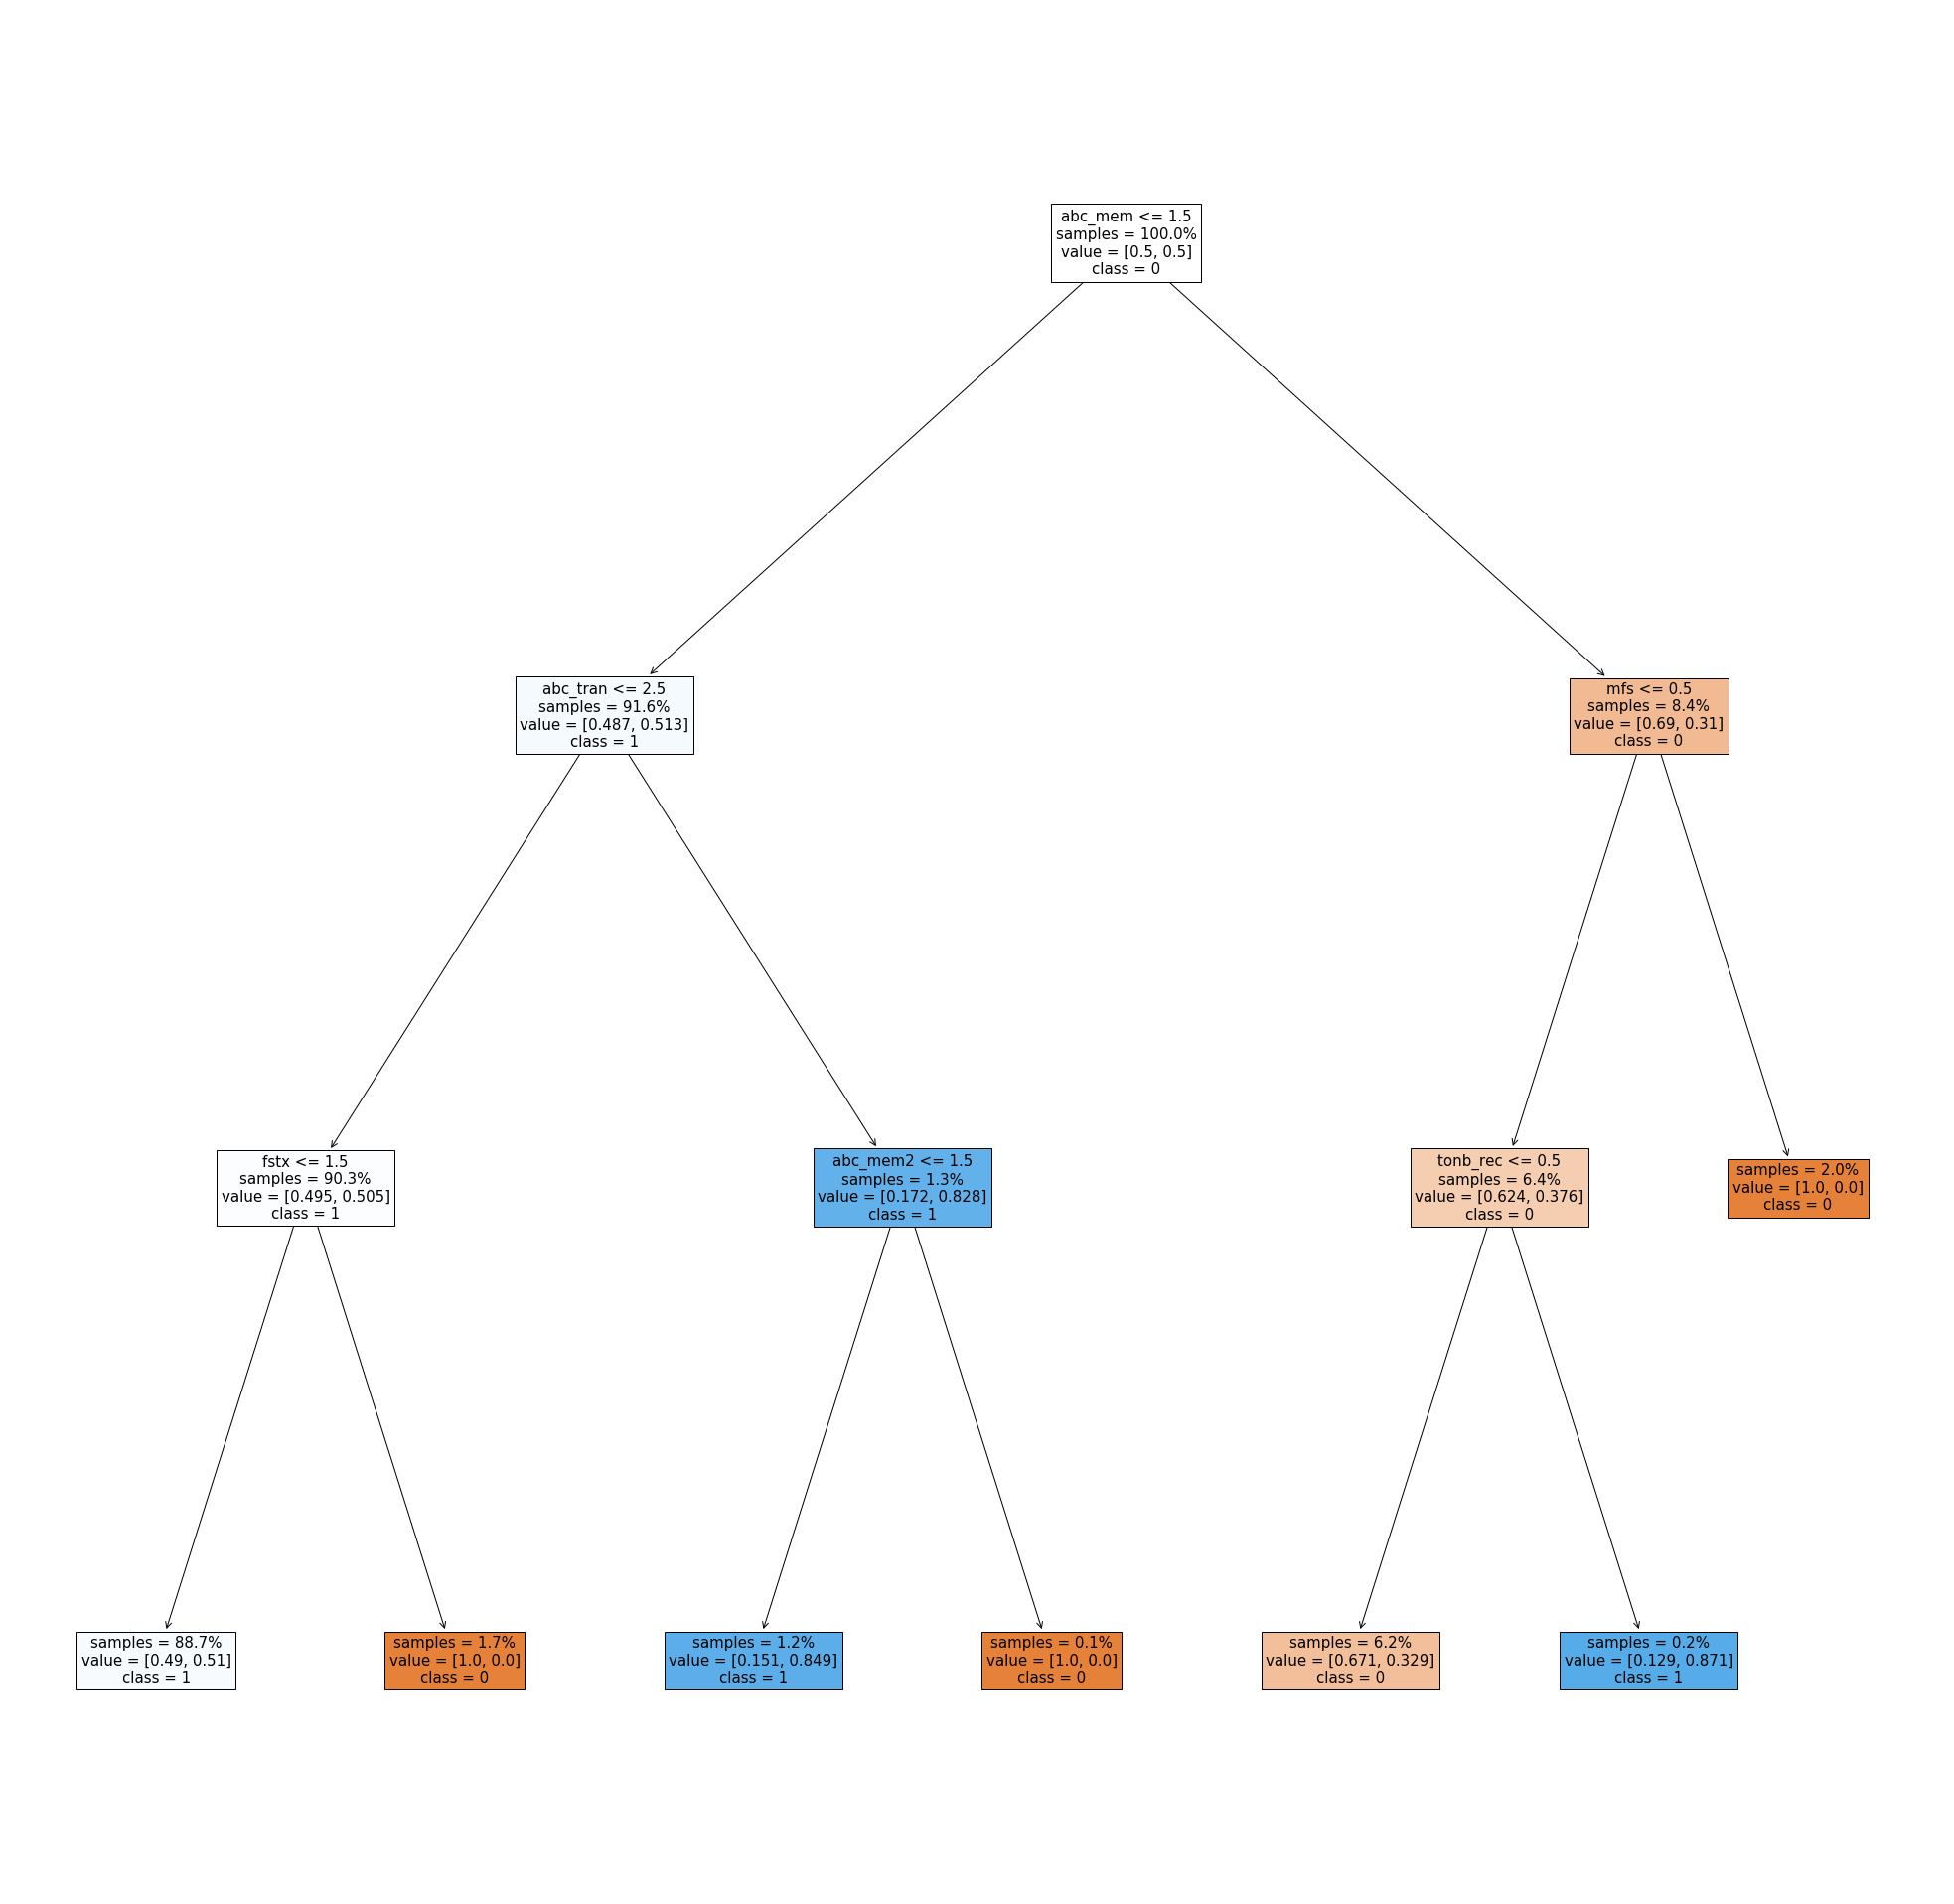

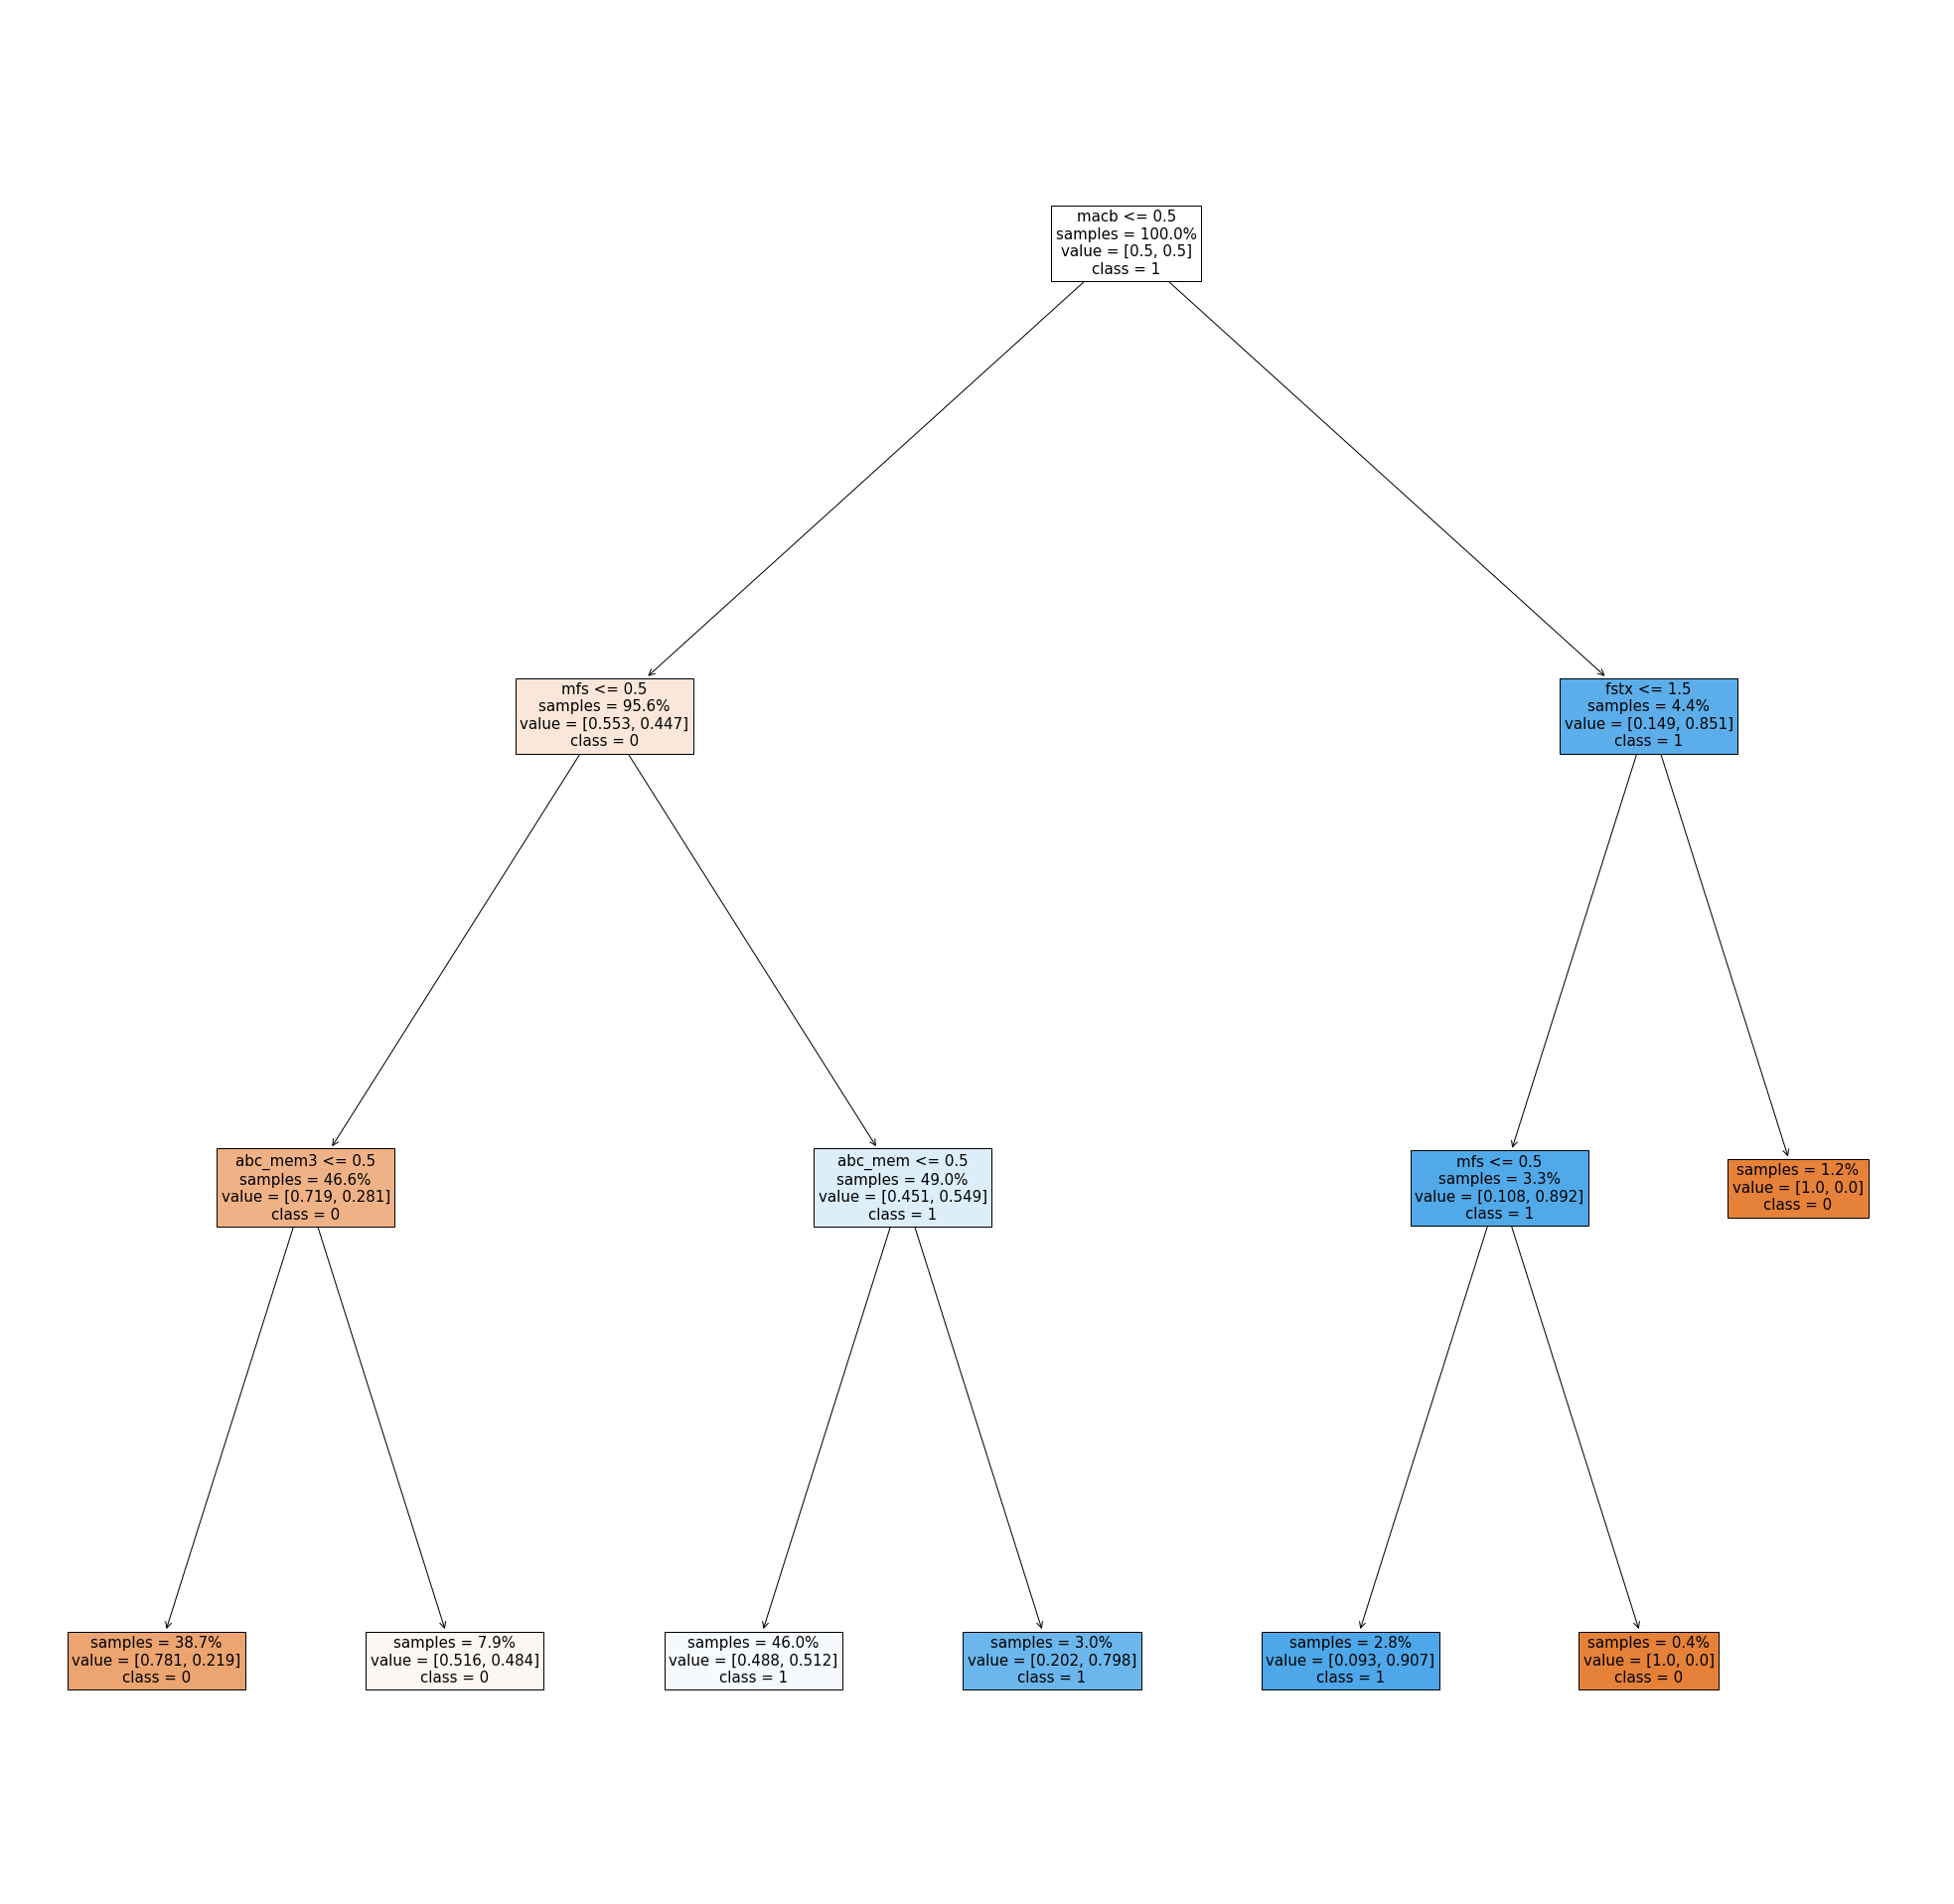

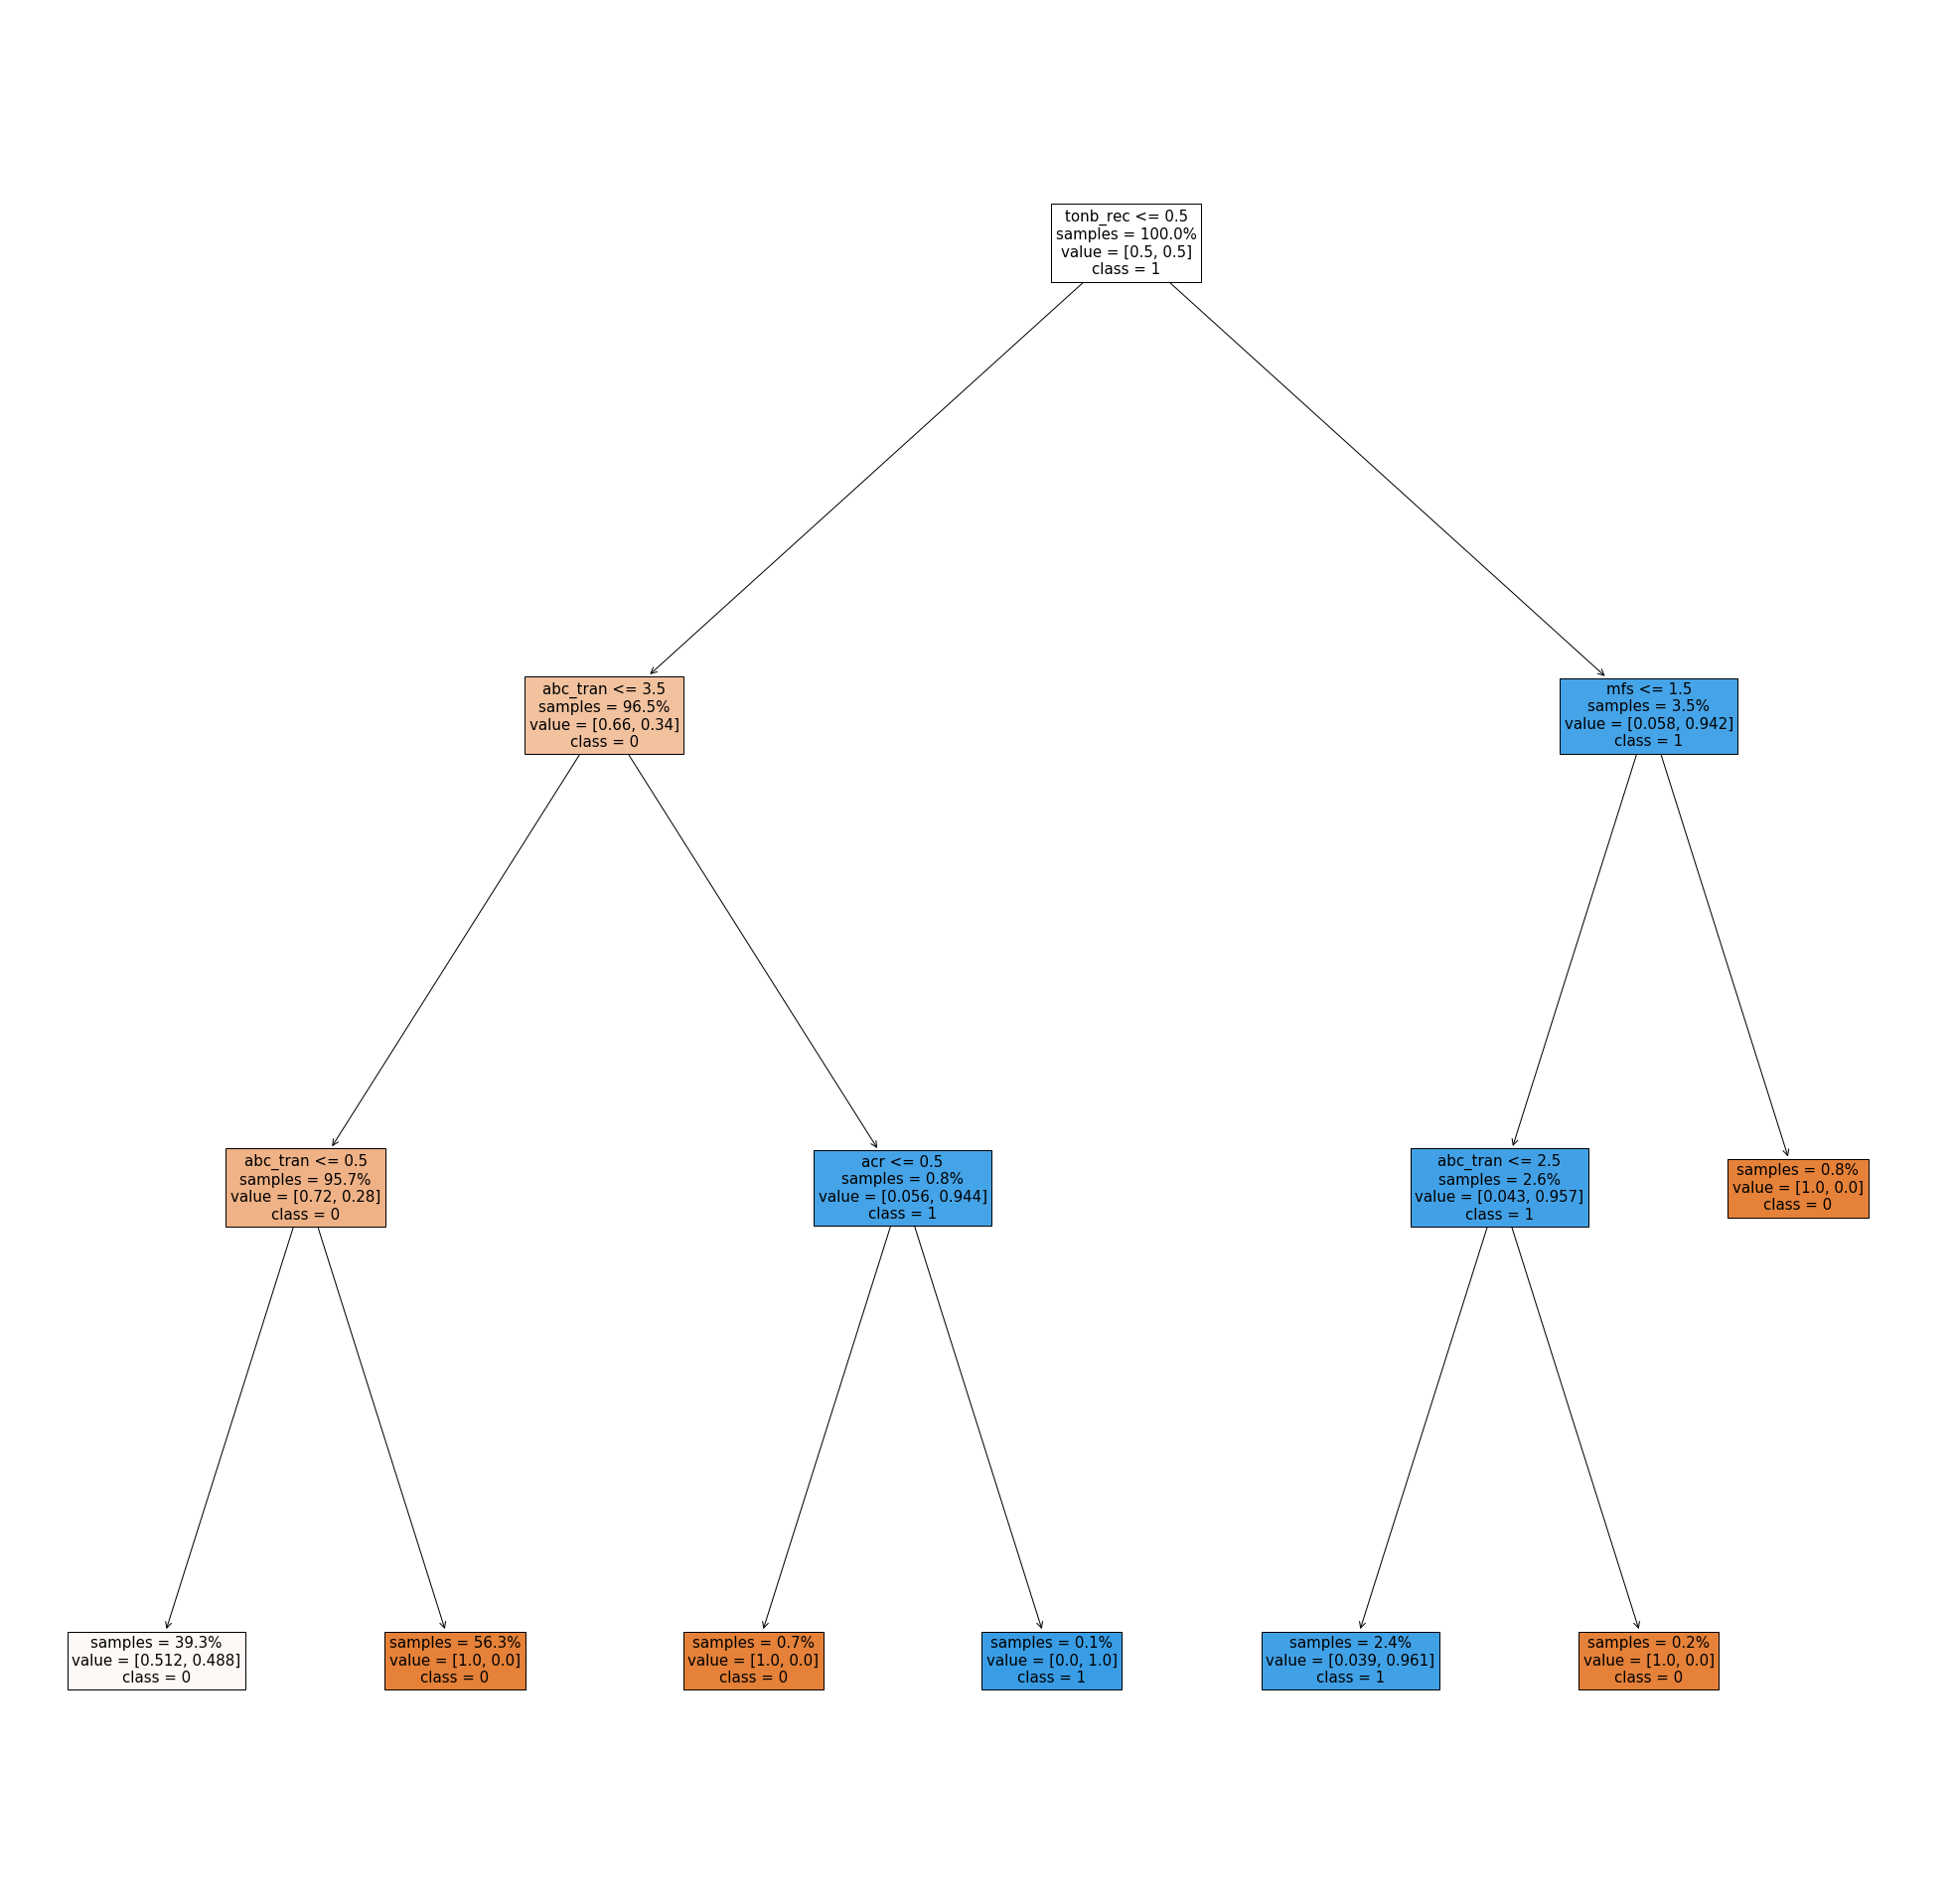

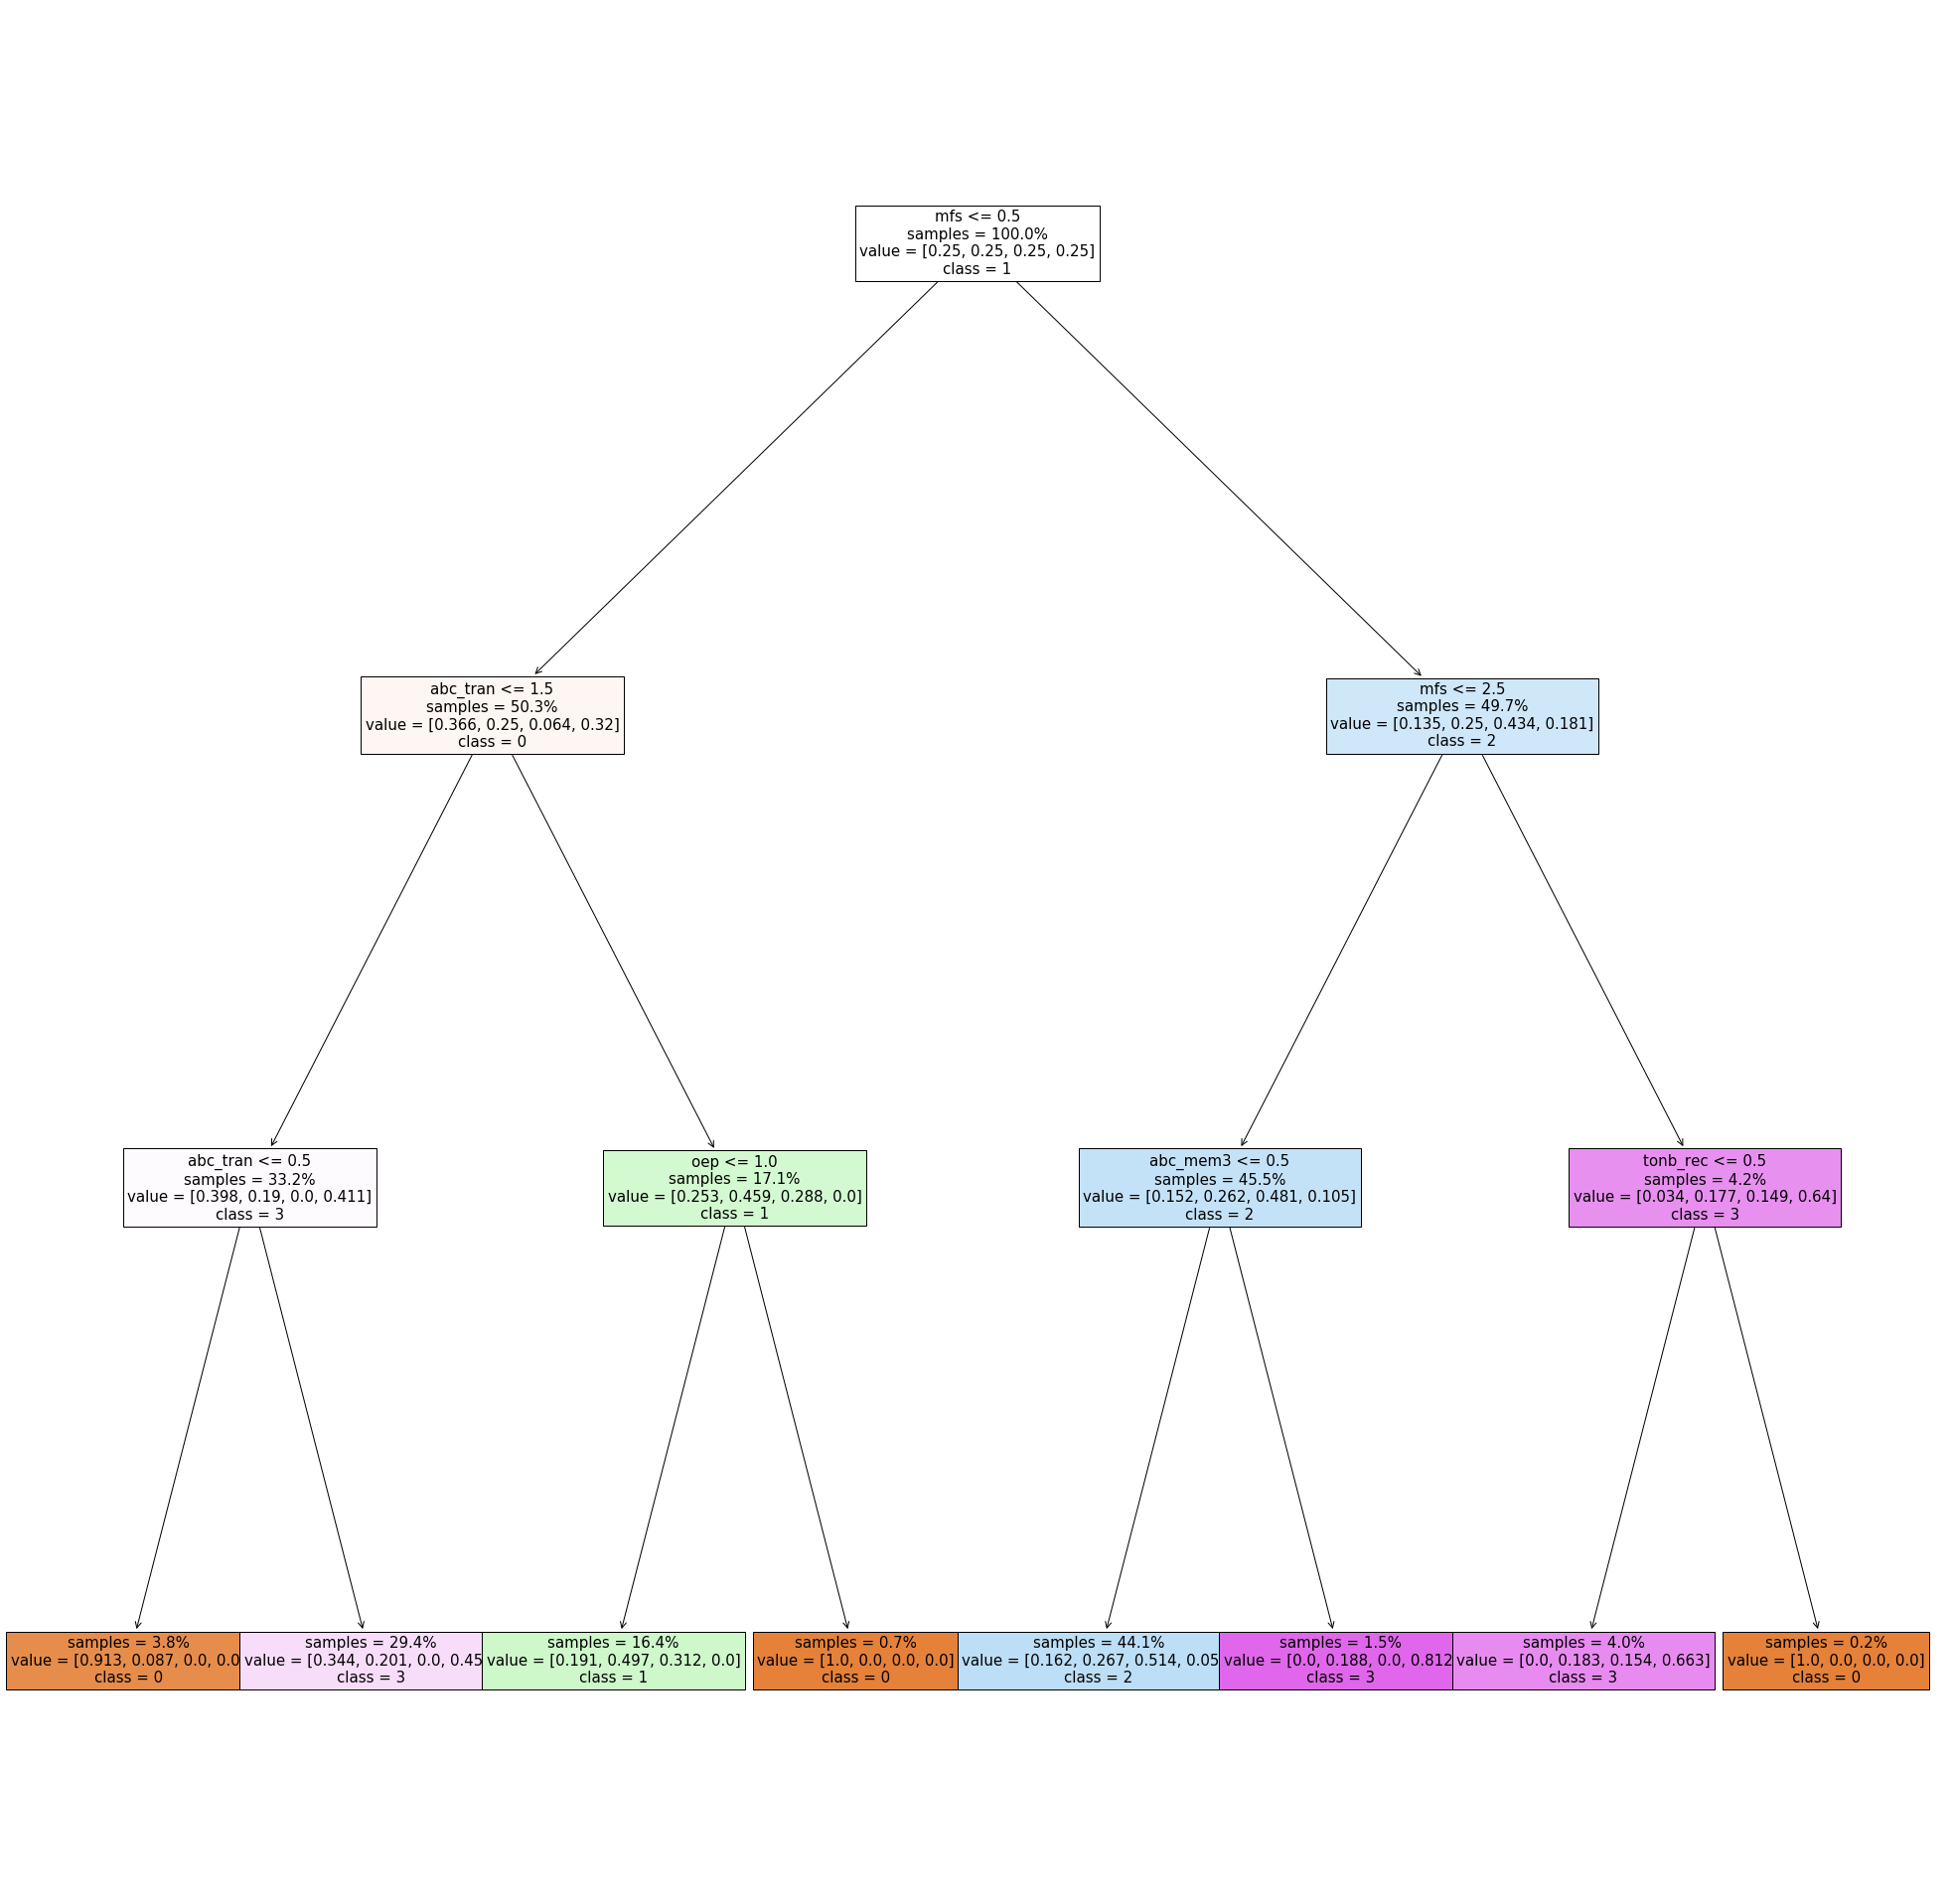

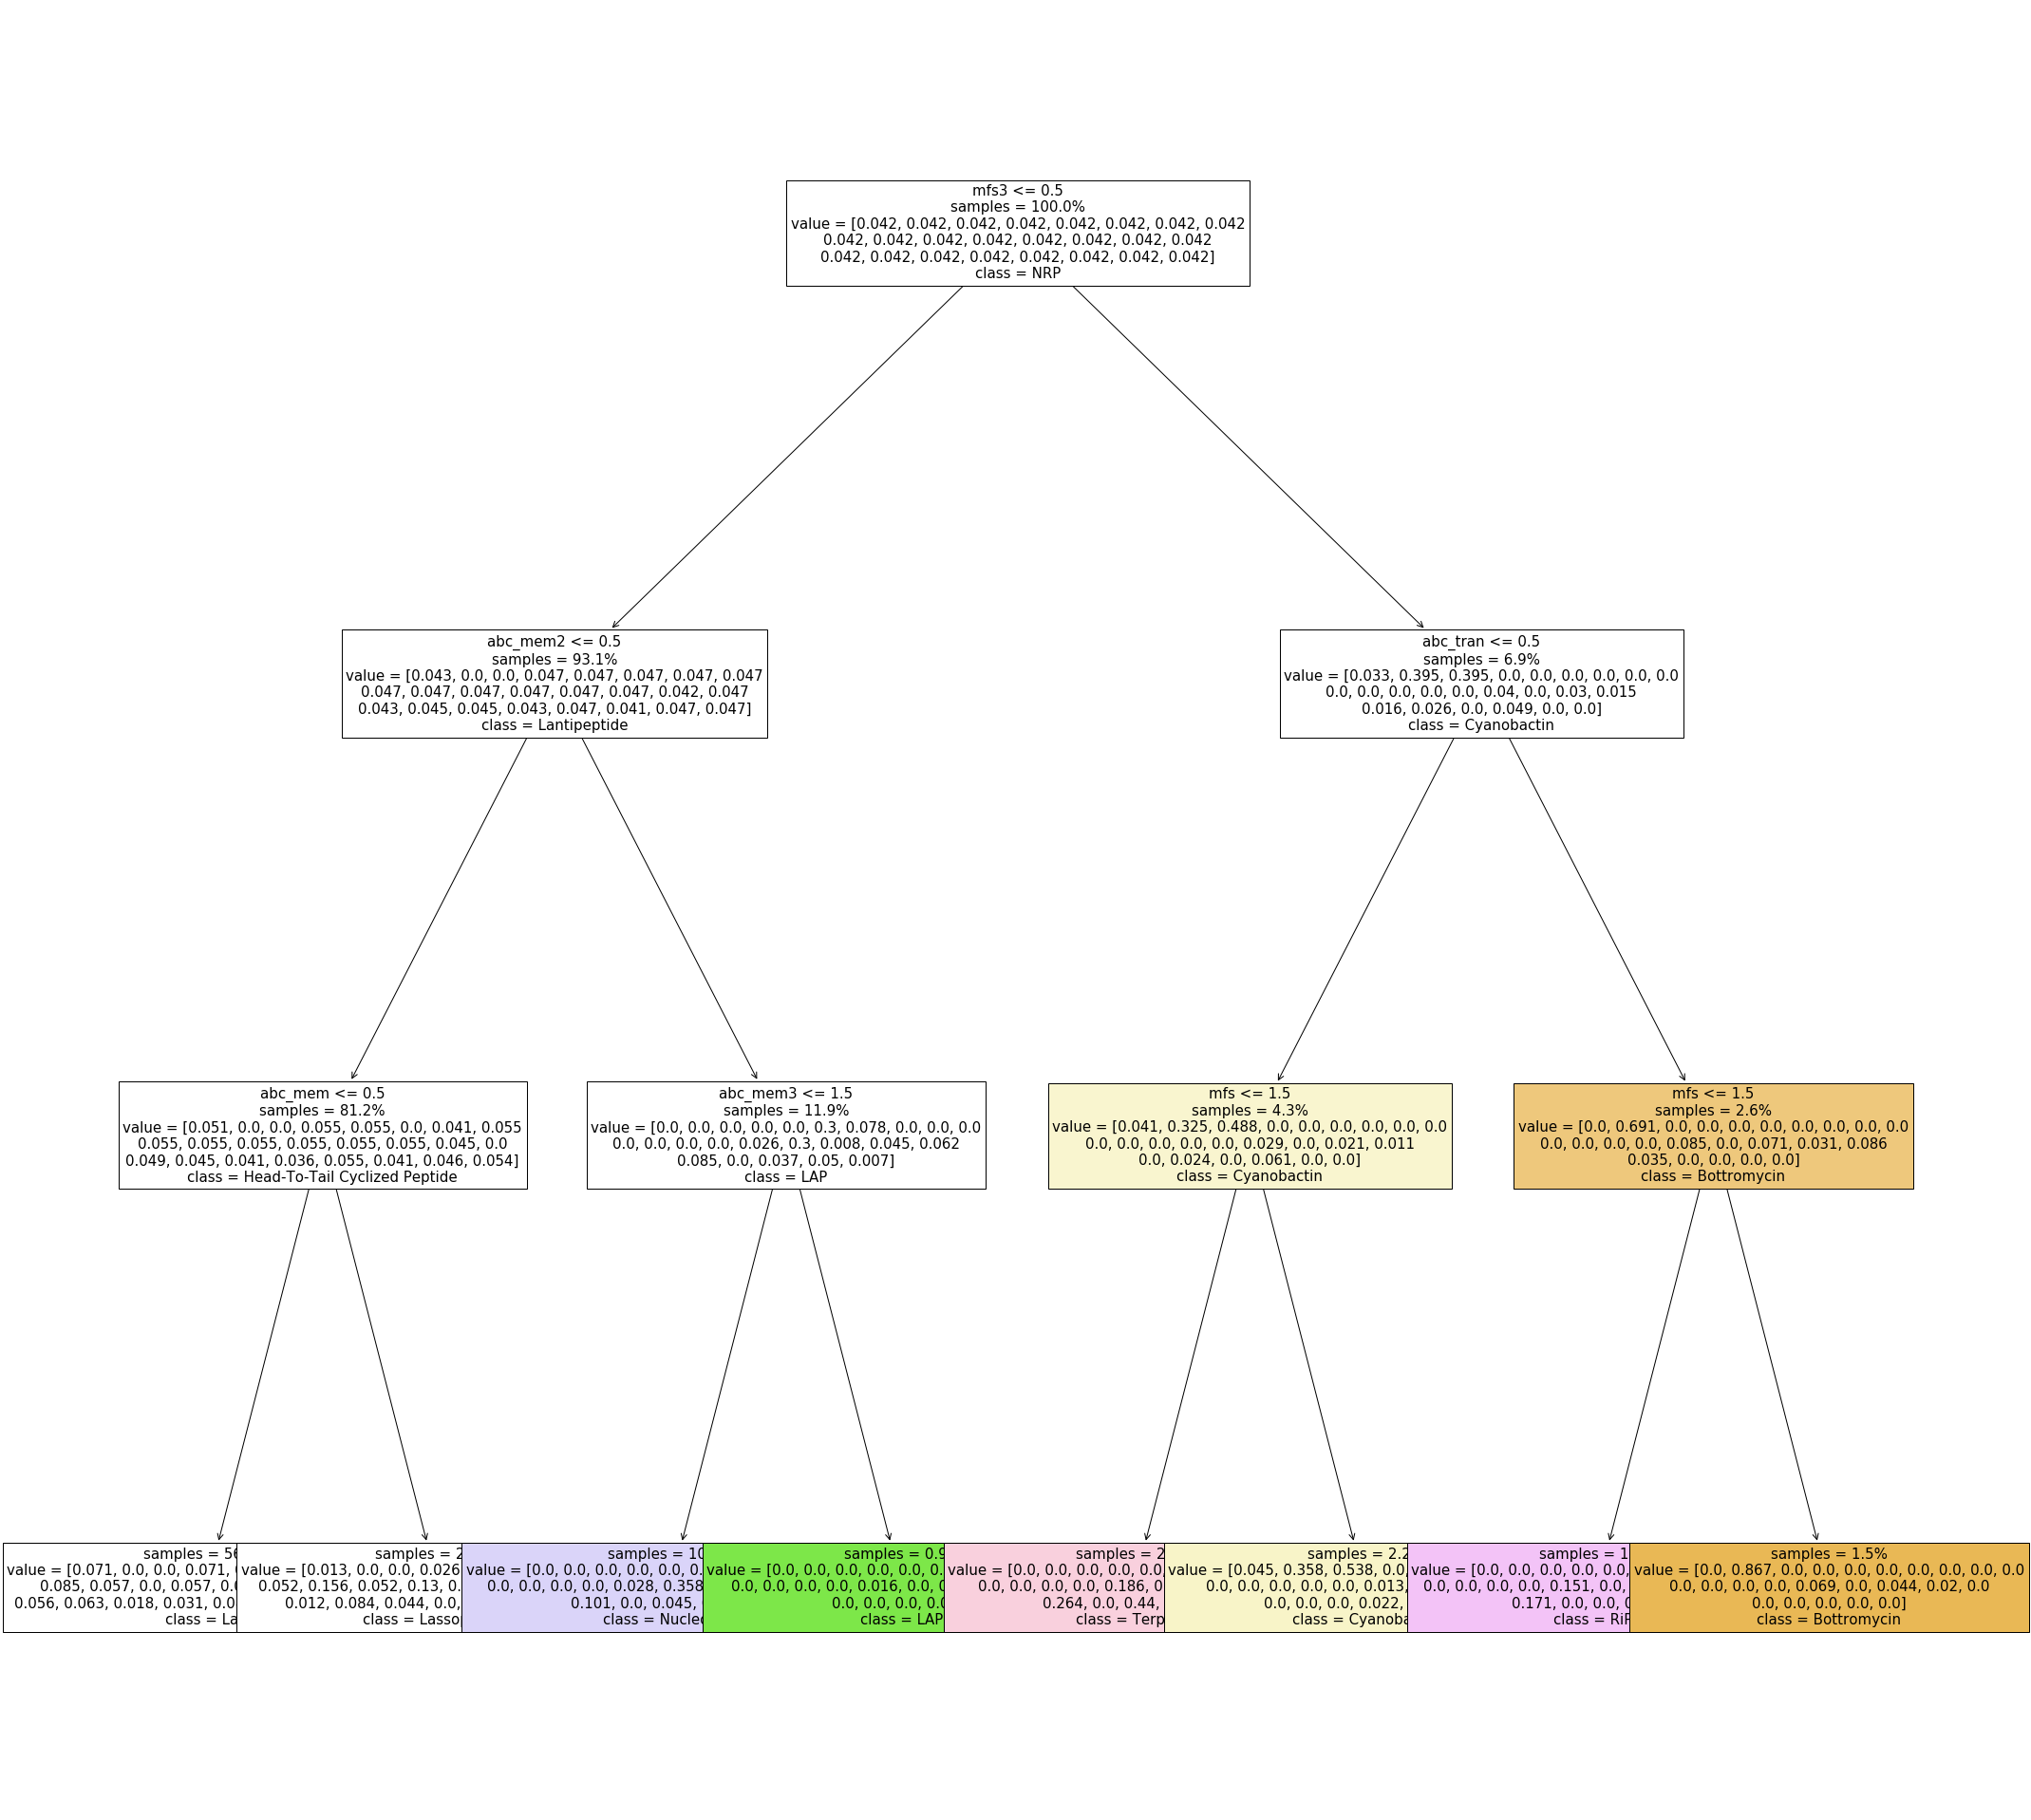

In [368]:
for trait in traits_of_interest:
    print('-'*70)
    print(f'Trait is {trait}')
    fit_and_plot_tree(mibig_counts, np.array(mibig_meta[trait]), pfam_colnames, trait)
    print('-'*70)